## Improving Accuracy of Simulated Flows in Steeply Dipping Layers Using Vertically Staggered Grids with the XT3D Multi-Point Flux Approximation in MODFLOW 6

In [1]:
%run ./routines.ipynb
%run ./figures.ipynb
ws = './disu_model'

In [2]:
domain = True              # option to include "domain" (True) or not (False)
spdis_recalc = True        # option to recalculate specific discharge within the notebook
dztol = 0.00001            # tolerance for determining overlap (dz > dztol) in a vertically staggered grid

In [3]:
# scenario parameters
# scenario names -- keys of parameters dictionary are scenario names
#                   built automatically from scenario options
# staggered -- vertically staggered grid, i.e., cross-connections (True)
#              or not, i.e., vertically offset (False)
# xt3d -- xt3d on (True) or off, i.e., standard formulation (False)

# scenario options
options = [
    {
        "optionname": "staggered",
        "optionstrings": {
            False: "-vo",
            True: "-vs",
        },
    },
    {
        "optionname": "xt3d",
        "optionstrings": {
            False: "-s",
            True: "-x",
        },
    },
]

# build parameters dictionary
parameters = build_parameters(options)

In [4]:
# Lx is the full width of the model. The grid spacing in the x direction is
# delr = Lx / ncol, and so the horizontal distance between the left and right
# boundary conditions is Lx - delr. The cells in the channel are square, i.e.,
# delz_chan = delr. The cross-sectional model has unit thickness "into the page,"
# i.e., nrow = 1 and delc = 1.

# The full thickness of the channel measured vertically is nlay_chan * delz_chan.
# Theta is the angle (deg) at which the channel slopes, and so the width of the
# "true" channel measured perpendicularly to the slope, i.e., the width available 
# for flow along the slope of the channel, is nlay_chan * delz_chan * cos(theta).
# The increase in elevation (vertical offset) as one moves a column to the right
# within the channel is delr * tan(theta).

# adjustable grid parameters
nlay_chan = 5                         # number of layers in channel
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model
theta = 40.                           # angle of inclination of channel
k_dom = 1.e-1                         # domain conductivity

# set up dis grid and conductivities
mgs, nlay_dom_upper, inchan, delz_chan, zspan, zthick, zthick_dom_ll \
    = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain)
cond = set_up_cond(k_dom)

# arrays for storing results
models_all, head_all, spdismf6_all, q_all, qx_all, qy_all, qz_all = [], [], [], [], [], [], []

# loop over scenarios
for i in range(len(parameters)):
    # convert to disu grid
    d2d = convert_to_disu(mgs, i, dztol)
    # run scenario and store results
    gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid = simulation(i)
    models_all.append(gwf), head_all.append(head), spdismf6_all.append(spdismf6)
    qx_all.append(qx), qy_all.append(qy), qz_all.append(qz)
    q_all.append((qmagmid, qangmid))

C:\Users\aprovost\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1019: UserWarning: Warning: converting a masked element to nan.
  u = np.array([u_tmp.ravel()[cell] for cell in sorted(projpts)])
C:\Users\aprovost\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1020: UserWarning: Warning: converting a masked element to nan.
  v = np.array([vz.ravel()[cell] for cell in sorted(projpts)])


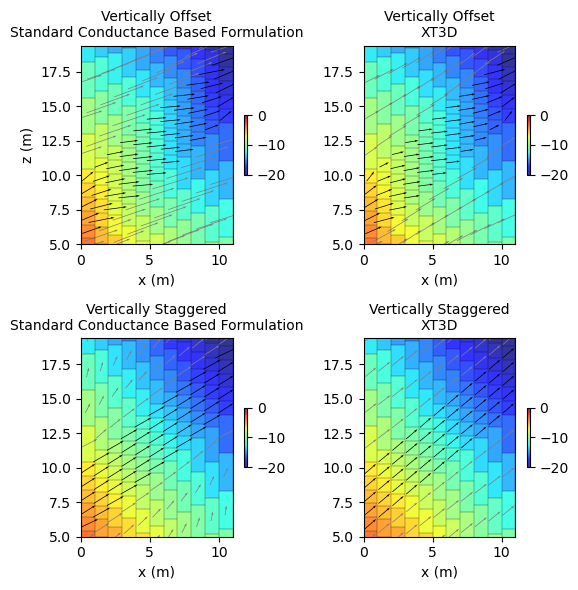

In [5]:
extent = (0., Lx, zthick_dom_ll, zthick_dom_ll + zspan + delz_chan)
#extent = None
fig2(vmin = -20, vmax = 0, extent=extent, scale_chan=10., scale_dom=10.*k_dom, normalize=False)

In [6]:
table1()

Vertically Offset
Standard Conductance Based Formulation
qmagmid =  1.3100828561040763
qangmid =  5.868344795352325 

Vertically Offset
XT3D
qmagmid =  1.0969387371780794
qangmid =  6.9714531206937025 

Vertically Staggered
Standard Conductance Based Formulation
qmagmid =  1.1553236766134531
qangmid =  32.05247875701014 

Vertically Staggered
XT3D
qmagmid =  1.0072682925604586
qangmid =  39.76576513897029 



### Investigating adding model layers within hydrogeologic layers 

In [7]:
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model
theta = 30.                           # angle of inclination of channel
k_dom = 1.e-6                         # domain conductivity

# grid resolution cases
resolution_scenarios = np.arange(1,10,1)
nr = len(resolution_scenarios)

# arrays for storing results
vo_results, vs_results = [], []

# loop over grid resolution cases
for n in range(nr):
    nlay_chan = resolution_scenarios[n]   # number of layers in channel
    # set up dis grid and conductivities
    mgs, nlay_dom_upper, inchan, delz_chan, zspan, zthick, zthick_dom_ll \
        = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain)
    cond = set_up_cond(k_dom)
    # run scenarios 1 and 3 (the two with XT3D) for this case and store results
        # convert to disu grid
    d2d = convert_to_disu(mgs, 1, dztol)
    gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid = simulation(1)  # VO(XT3D)
    vo_results.append((nlay_chan, qmagmid, qangmid))
    d2d = convert_to_disu(mgs, 3, dztol)
    gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid = simulation(3)  # VS(XT3D)
    vs_results.append((nlay_chan, qmagmid, qangmid))

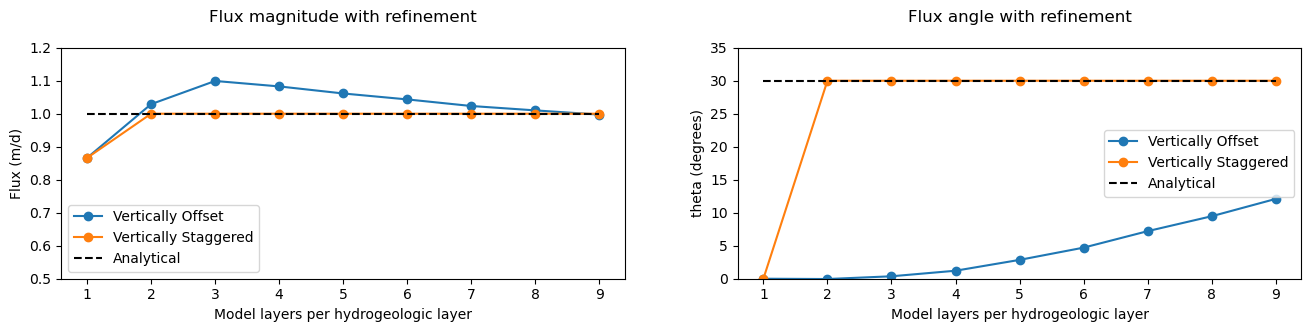

In [8]:
fig3()

### Investigating K contrast between hydrogeologic layer and domain

In [ ]:
nlay_chan = 5                         # number of layers in channel
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model

# dip and K contrast cases
dip = np.arange(0, 80, 2.5)   # For nice contours use (0,80,1)
#log = np.arange(0, 3, 0.5)    # For nice contours use (0,4,0.2)
log = [0.25, 0.5, 1, 2]
Kcontrast = [10**i for i in log]

# arrays for storing results
qmag_results = np.zeros((4, len(Kcontrast), len(dip)))
qang_results = np.zeros((4, len(Kcontrast), len(dip)))
dip_array = np.zeros((4, len(Kcontrast), len(dip)))
Kcontrast_array = np.zeros((4, len(Kcontrast), len(dip)))

# loop over scenarios
for s in range(len(parameters)):
    # loop over dip cases
    for d in range(len(dip)):
        theta = dip[d]                        # angle of inclination of channel
        # set up dis grid
        mgs, nlay_dom_upper, inchan, delz_chan, zspan, zthick, zthick_dom_ll \
            = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain)
        d2d = convert_to_disu(mgs, s, dztol)
        # loop over K contrast cases
        for kc in range(len(Kcontrast)):
            k_dom = 1./Kcontrast[kc]              # domain conductivity
            # set up conductivities
            cond = set_up_cond(k_dom)
            # run case and store results
            #print('\nk_contrast = %i, dip = %i, scenario = %i' %(Kcontrast[kc], dip[d], s))
            gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid = simulation(s)
            qmag_results[s][kc][d] = qmagmid
            qang_results[s][kc][d] = qangmid  
            Kcontrast_array[s][kc][d] = Kcontrast[kc]
            dip_array[s][kc][d] = dip[d]

In [ ]:
fig4alt2()

In [ ]:
#fig4alt()

In [ ]:
#fig4()